In [44]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import jax
import arviz as az

from numpyro.infer import NUTS,MCMC,Predictive

In [23]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

In [24]:
# load data 
data = pd.DataFrame({
    
    'yield':[ 7, 13, 13, 11,  5,  6,  8, 11, 10, 11, 11, 11, 11, 14,  8, 15, 10,
        9, 13, 12,  8, 15,  7, 11,  5, 11, 15, 10, 13,  9,  8, 12, 13,  6,
        8,  5, 13,  8,  5, 10, 18,  9,  7, 12, 11,  5,  9, 10, 13, 13,  7,
       12,  8, 16, 10,  6, 12, 13, 10, 12,  9,  7, 12, 11,  8, 15, 13, 11,
        9, 17, 11, 10, 15, 19, 11, 13, 12,  9, 10, 10],
    
    'group':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
})

In [25]:
import seaborn as sns

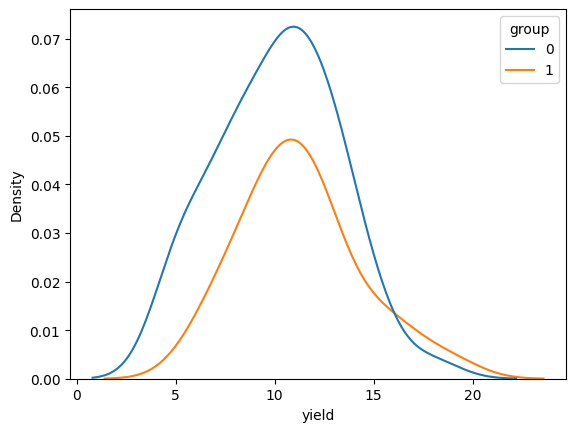

In [26]:
sns.kdeplot(data = data ,x="yield",hue="group",);

In [ ]:
# "Given these observed values y, what is the most plausible value (or distribution) of the Poisson rate mu that likely generated them?"

# Or more formally:

# "What is the posterior distribution of mu given the observed data y?"

In [ ]:
# P(μ)=HalfNormal(10)   → prior
# P(y∣μ)=Poisson(μ)     → likelihood

In [27]:
data.shape

(80, 2)

In [30]:
y = data[data["group"]==0]["yield"].values

In [31]:
y

array([ 7, 13, 13, 11,  5,  6,  8, 11, 10, 11, 11, 11, 11, 14,  8, 15, 10,
        9, 13, 12,  8, 15,  7, 11,  5, 11, 15, 10, 13,  9,  8, 12, 13,  6,
        8,  5, 13,  8,  5, 10, 18,  9,  7, 12, 11,  5,  9, 10, 13, 13])

In [32]:
# def model ( y= None, num_data = 0):
#     # prior
#     mu = numpyro.sample("mu", dist.HalfNormal(scale = 10))
#     # likelihood

#     with numpyro.plate("data", num_data):
#         numpyro.sample("obs", dist.Poisson(mu), obs=y)

def model(y=None, num_data = 0):
    
    # Since the Poisson rate parameter must be ≥ 0, using HalfNormal ensures positivity.
    mu = numpyro.sample('mu', dist.HalfNormal(10))
    
    # This is vectorizing the next operation over num_data points — equivalent to looping over the data.
    # n probabilistic terms, you're saying:
    # I have num_data independent observations from the same distribution.
    
    with numpyro.plate('data', num_data):
        numpyro.sample('obs', dist.Poisson(mu), obs=y)

In [33]:
nuts = NUTS(model)
mcmc = MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)

mcmc.run(jax.random.PRNGKey(0), y=y, num_data=len(y))
mcmc_samples = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

/tmp/ipykernel_11999/3795246695.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)
sample: 100%|██████████| 3500/3500 [00:00<00:00, 5728.00it/s, 1 steps of size 8.38e-01. acc. prob=0.93]


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

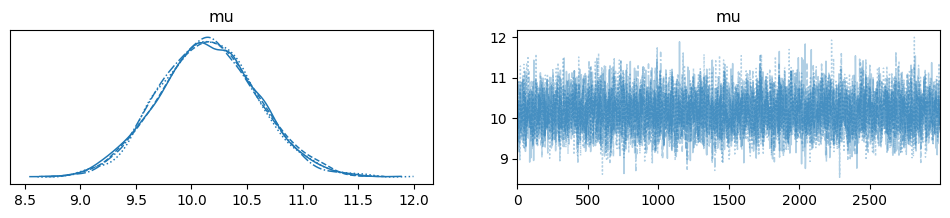

In [34]:
az.plot_trace(idata)
# plt.gcf().subplots_adjust(wspace=0.5, hspace=0.5)

In [35]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,10.155,0.445,9.322,10.991,0.006,0.004,4902.0,6320.0,1.0


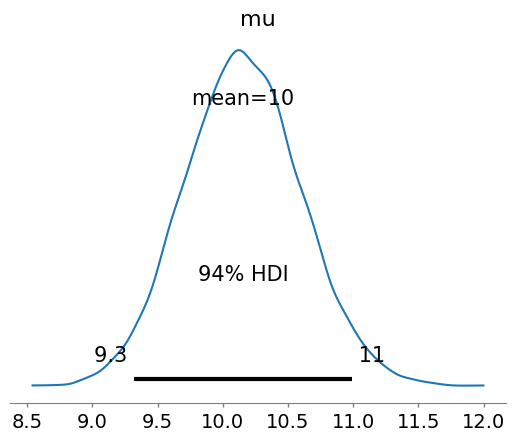

In [36]:
az.plot_posterior(idata);
#az.plot_posterior(idata, hdi_prob=0.95);

In [37]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [38]:
idata.posterior['mu']

<xarray.DataArray 'mu' (chain: 4, draw: 3000)> Size: 48kB
array([[10.271109, 10.275216, 10.255319, ...,  9.898605,  9.860763,
        10.485059],
       [10.873682, 10.446373, 10.080483, ..., 10.173126,  9.700063,
        10.278112],
       [10.021342, 10.16986 , 10.196375, ..., 10.275566, 10.358771,
         9.895351],
       [10.2695  ,  9.19502 ,  9.310597, ...,  9.959224,  9.832872,
         9.841269]], shape=(4, 3000), dtype=float32)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 24kB 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999

In [40]:
predictive = Predictive(model, mcmc_samples)

ppc_samples = predictive(jax.random.PRNGKey(1), num_data=len(y))

idata_ppc = az.from_numpyro(mcmc, posterior_predictive=ppc_samples)

In [41]:
ppc_samples['obs'].shape

(12000, 50)

In [42]:
ppc_mean = ppc_samples['obs'].mean(axis=1)
ppc_var = ppc_samples['obs'].var(axis=1)

In [43]:
ppc_mean.shape

(12000,)

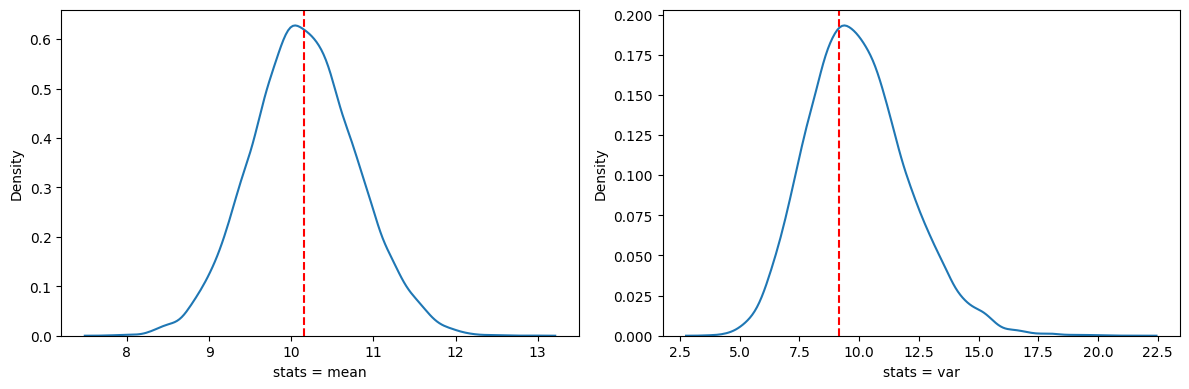

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.kdeplot(ppc_mean, ax=axes[0])
axes[0].axvline(y.mean(), color='r', linestyle='dashed')
axes[0].set_xlabel('stats = mean')

sns.kdeplot(ppc_var, ax=axes[1])
axes[1].axvline(y.var(), color='r', linestyle='dashed')
axes[1].set_xlabel('stats = var')

plt.tight_layout()

In [46]:
idata_ppc

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

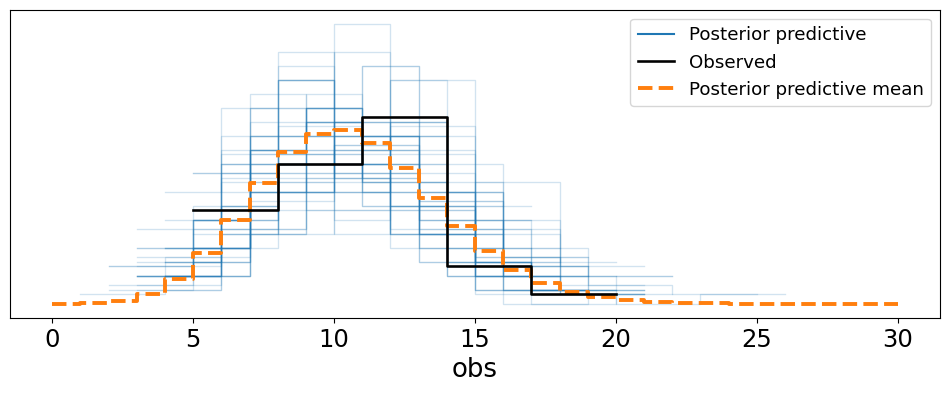

In [47]:
az.plot_ppc(idata_ppc, kind='kde', num_pp_samples=50, figsize=(12, 4));

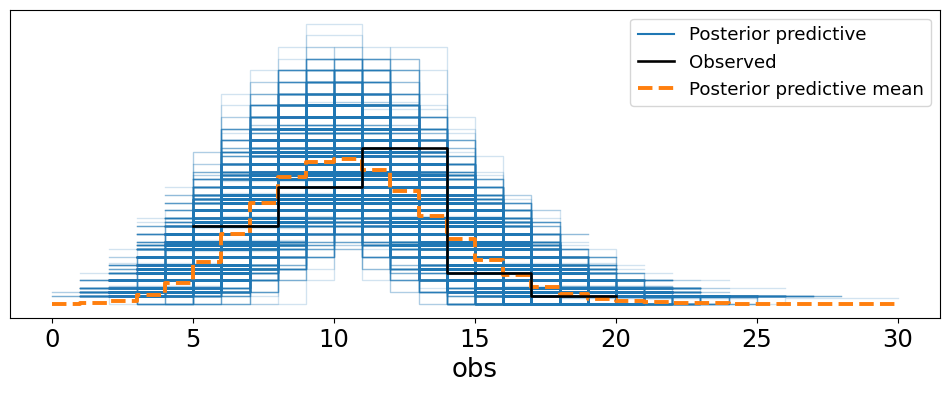

In [48]:
az.plot_ppc(idata_ppc, kind='kde', num_pp_samples=3000, figsize=(12, 4));